# 직접 만들어본 머신러닝 알고리즘

- 머신러닝 알고리즘을 완벽하게 이해하기 위하여 학교수업 혹은 구글링을 바탕으로 관련 수식을 이해하고 알고리즘을 만들어 보았다.
- sikit-learn 모듈처럼 class 안에 fit, predict, score 함수를 넣어 구현하였다.
- fit(X_train, y_train) : train data를 적합시키고 모델을 만든다.
- predict(X_test) : 분류기일 경우, 예측 특성값이 들어있는 벡터를 반환한다.
- score(X_test, y_test) : 정답레이블과 예측레이블을 비교하여 정확도를 반환한다.

## 서포트 벡터 머신

### 1. 알고리즘

In [1]:
import numpy as np
import cvxopt as co

class svm_classifier:
    '''
    이진분류만 가능하며 라벨값은 0, 1로 받는다.
    슬랙변수를 추가한 모형(soft SVM)은 추후에 만들 예정
    '''
    
    def fit(self, X_train, y_train):
        
        n_samples, n_feature = X_train.shape
        y_train[y_train == 0] = -1
        y_train = y_train.reshape(-1, 1)
        
        # 이차계획법 (Quadratic Programming)
        P = np.dot((X_train.T * y_train.T).T, (X_train.T * y_train.T)).astype('double')
        q = -np.ones(n_samples).astype('double')
        G = -np.eye(n_samples).astype('double')
        h = np.zeros(n_samples).astype('double')
        A = y_train.T.astype('double')
        
        P = co.matrix(P)
        q = co.matrix(q)
        G = co.matrix(G)
        h = co.matrix(h)
        A = co.matrix(A)
        b = co.matrix(0.0)
        
        # 수치 오류 해결
        sol = np.ravel(co.solvers.qp(P, q, G, h, A, b)['x'])
        lagrange_multiplier = sol[sol > 1e-5]
        sv_X_train = X_train[sol > 1e-5]
        sv_y_train = y_train.flatten()[sol > 1e-5]
        weight = (lagrange_multiplier * sv_y_train * sv_X_train.T).sum(axis = 1)
        
        if sv_y_train[0] == -1:    
            bias = np.dot(weight, sv_X_train[0]) + 1
        elif sv_y_train[0] == 1:
            bias = np.dot(weight, sv_X_train[0]) - 1
        else:
            pass
        
        y_train[y_train == -1] = 0
        
        # 기울기와 절편
        self.weight = weight
        self.bias = bias
    
    def predict(self, X_test):
        
        criteria = np.dot(X_test, self.weight) - self.bias > 0
        y_pred = criteria.astype(int)
        return y_pred
    
    def score(self, X_test, y_test):
        return np.mean(self.predict(X_test) == y_test)

### 2. 검증

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples = 200, centers = 2, n_features=2, random_state=0, cluster_std = 0.4)

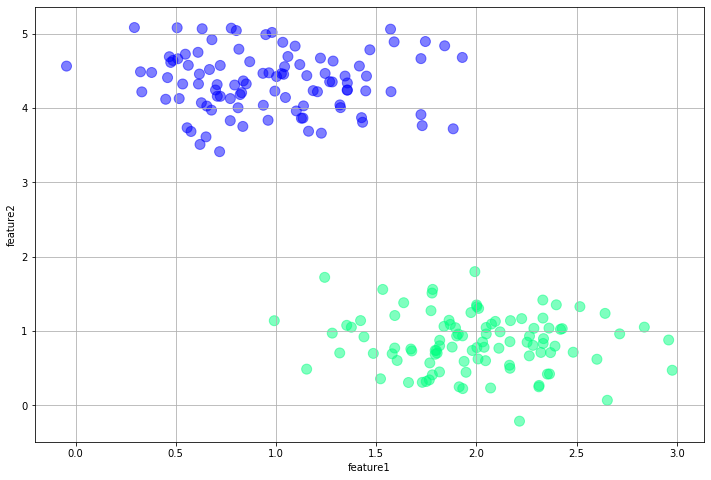

In [3]:
plt.figure(figsize = (12, 8))
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = 'winter', s = 100, alpha = 0.5)
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.grid()
plt.show()

- 위와 같은 데이터 셋을 머신러닝 모델을 이용하여 예측하고자 한다.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
svm = svm_classifier() # 위에서 만든 지도학습 알고리즘
svm.fit(X_train, y_train) # train data 적합
y_pred = svm.predict(X_test) # 예측 레이블 반환
print('예측 스코어 : ' + str(svm.score(X_test, y_test))) # 예측률 반환

     pcost       dcost       gap    pres   dres
 0: -6.2834e+00 -1.0174e+01  4e+02  2e+01  2e+00
 1: -2.6062e+00 -1.3582e+00  2e+01  1e+00  1e-01
 2: -8.7881e-02 -9.7159e-01  9e-01  3e-04  3e-05
 3: -3.5651e-01 -5.3998e-01  2e-01  6e-05  5e-06
 4: -3.9482e-01 -5.5606e-01  2e-01  4e-05  3e-06
 5: -4.7458e-01 -5.4235e-01  7e-02  2e-05  1e-06
 6: -5.2965e-01 -5.3202e-01  2e-03  4e-07  4e-08
 7: -5.3162e-01 -5.3164e-01  2e-05  5e-09  4e-10
 8: -5.3164e-01 -5.3164e-01  2e-07  5e-11  4e-12
Optimal solution found.
예측 스코어 : 1.0


- 훈련 데이터로 만들어진 모델에 대한 테스트셋의 정확도는 1.0이다.
- 그래프를 통해 확인해보도록 하자

In [29]:
x = np.arange(-2, 5, 0.01)
hyperplane = (-svm.weight[0] / svm.weight[1]) * x + (svm.bias / svm.weight[1])

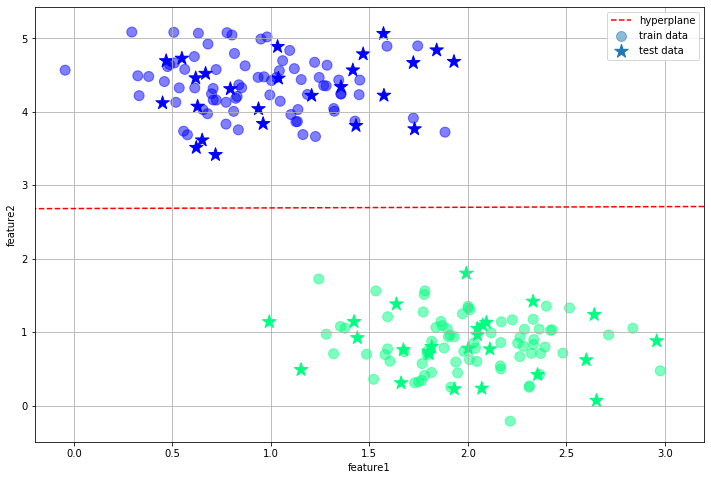

In [30]:
plt.figure(figsize = (12, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = 'winter', label = 'train data', s = 100, alpha = 0.5)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_pred, cmap = 'winter', label = 'test data', s = 200, marker = '*')
plt.plot(x, hyperplane, c = 'r', ls = '--', label = 'hyperplane')
plt.legend()
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.xlim(-0.2, 3.2)
plt.grid()
plt.show()

- 붉은 점선 : 하이퍼플레인을 기준으로 분류가 잘 된것을 확인할 수 있다.